In [8]:
import numpy as np
import cv2
import matplotlib.pyplot as plt
import math
from mpl_toolkits.mplot3d import Axes3D
import utils

In [2]:
K = np.loadtxt('Glyp/K.txt')

impath = 'Glyp/sequence/'
im0 = cv2.imread(impath + '000001.png', cv2.IMREAD_GRAYSCALE)
im1 = cv2.imread(impath + '000002.png', cv2.IMREAD_GRAYSCALE)
im2 = cv2.imread(impath + '000003.png', cv2.IMREAD_GRAYSCALE)

In [3]:
sift = cv2.SIFT.create()
kp0, des0 = sift.detectAndCompute(im0, None)
kp1, des1 = sift.detectAndCompute(im1, None)
kp2, des2 = sift.detectAndCompute(im2, None)

kp0 = np.array([k.pt for k in kp0])
kp1 = np.array([k.pt for k in kp1])
kp2 = np.array([k.pt for k in kp2])

bf = cv2.BFMatcher_create(crossCheck=True)
matches01 = bf.match(des0, des1)
matches12 = bf.match(des1, des2)

matches01 = np.array([(m.queryIdx, m.trainIdx) for m in matches01])
matches12 = np.array([(m.queryIdx, m.trainIdx) for m in matches12])

Estimating E with RANSAC. The mask returned by this function indicates which
of the matches are inliers. The mask returned by cv2.recoverPose indicates which matches, that lie in front of both cameras.
Combine this mask with the mask from cv2.findEssentialMat, to get the matches that are both inliers and lie in front of both cameras.

In [4]:
E, E_mask = cv2.findEssentialMat(kp0[matches01[:,0]], kp1[matches01[:,1]])
retval1, R1, t1, recover_mask1 = cv2.recoverPose(E, kp0[matches01[:,0]], kp1[matches01[:,1]], K)
recover_mask1 = recover_mask1 // 255
mask1 = [(a & b)[0] for a, b in zip(E_mask, recover_mask1)]

In [5]:
print(E_mask.astype(int).sum())
print(recover_mask1.astype(int).sum())
print(sum(mask1))

2385
7757
2384


In [6]:
matches01_filtered = []
for i in range(len(mask1)):
    if mask1[i]:
        matches01_filtered.append(matches01[i])

matches01_filtered = np.asarray(matches01_filtered)

In [7]:
_, idx01, idx12 = np.intersect1d(matches01_filtered[:,1], matches12[:,0], return_indices=True)

points0 = kp0[matches01_filtered[idx01, 0]]
points1 = kp1[matches01_filtered[idx01, 1]]
points2 = kp2[matches12[idx12, 1]]

In [15]:
R0 = np.eye(3)
t0 = np.array([[0, 0, 0]]).T

P0 = utils.getP(K, R0, t0.T)
P1 = utils.getP(K, R1, t1.T) # The one we estimated

Q = []
for i in range(len(points0)):
    q0 = np.expand_dims(points0[i], axis=0).T
    q1 = np.expand_dims(points1[i], axis=0).T
    q = np.concatenate((q0, q1), axis=1)
    Q.append(utils.Pi(utils.triangulate(q, [P0, P1])))

Q = np.squeeze(np.asarray(Q))

Using the 2D positions in image 2 and the 3D points, estimate the pose of image 2 with RANSAC. 

In [16]:
_, R2vec, t2, inliers = cv2.solvePnPRansac(Q, points2, K, np.zeros(5))
R2 = cv2.Rodrigues(R2vec)[0]

Positions of the cameras:

In [17]:
p0x, p0y, p0z = t0
p1x, p1y, p1z = -R1.T @ t1
p2x, p2y, p2z = -R2.T @ t2

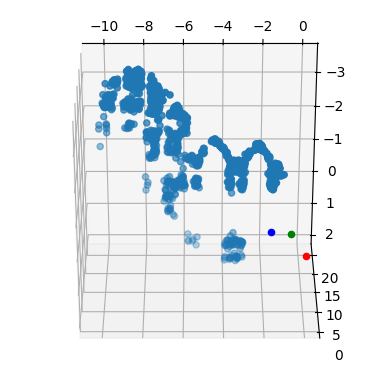

In [18]:
fig = plt.figure()
ax = fig.add_subplot(projection='3d')
x, y, z = Q[inliers.flatten()].T
ax.scatter(x, y, z)
ax.scatter(p0x, p0y, p0z, color='r')
ax.scatter(p1x, p1y, p1z, color='g')
ax.scatter(p2x, p2y, p2z, color='b')
ax.view_init(-60, -90)